In [1]:
import Wavefront_Generation as WG
import Wavefront_Plotting as WP
import Wavefront_Interactive as WI
from LTSpice_Simulator import get_Spice_Arrays
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal
%matplotlib widget

# Compare 2 Interfaces - 
---

$T_L$ = 7s , $T_C$ = 1s    V.S    $T_L$ = 1s, $T_C$ = 7s 

In [2]:
C_current = Decimal('1') # C = T/Z

In [69]:
# plt.rcParams["figure.figsize"] = (14, 7)
# simulate interfaces
(Interface_L_big) = WG.Full_Cycle(L_time = '3' ,C_time = '5.7',C_impedance = '5.7',L_impedance='1000',show_about =False)
(Interface_C_big) = WG.Full_Cycle(L_time = '3' ,C_time = '1.01',C_impedance = '1.01',L_impedance='1000',show_about = False)

# simulate verifiation data
time_step_divisor = Decimal('8')
LTSpice_L_big = get_Spice_Arrays(**Interface_L_big.data_input.SPICE_input_values,Step_size=str(Interface_L_big.data_input.GCD/time_step_divisor))
LTSpice_C_big = get_Spice_Arrays(**Interface_C_big.data_input.SPICE_input_values,Step_size=str(Interface_C_big.data_input.GCD/time_step_divisor))

Plot the values at the interconnects:

(0.0, 172.0)

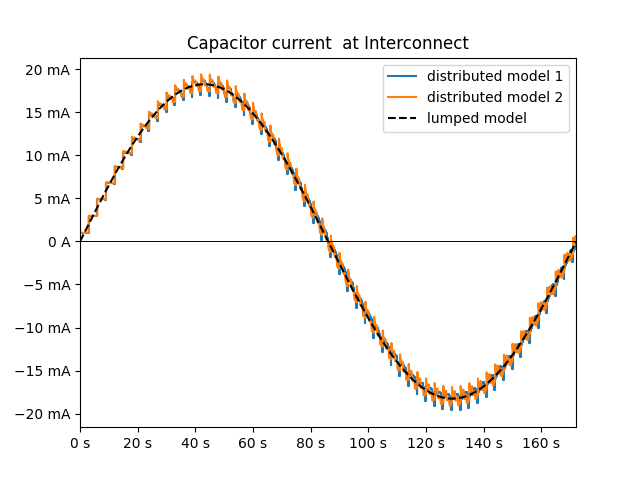

In [85]:
fig_compare,ax_compare= plt.subplots()

WP.plot_time_interconnect(Interface_L_big,ax_compare,'current capacitor')
WP.plot_time_interconnect(Interface_C_big,ax_compare,'current capacitor')
ax_compare.plot(LTSpice_L_big['Time'],LTSpice_L_big['Capacitor_Current_Circuit'])

lines = ax_compare.get_lines()
lines[2].set_color('black')
lines[2].set_linestyle('--')

ax_compare.legend(['distributed model 1','distributed model 2','lumped model'])

ax_compare.axhline(y=0,c='k',linestyle='-',linewidth=0.7)

ax_compare.set_xlim(0,172)

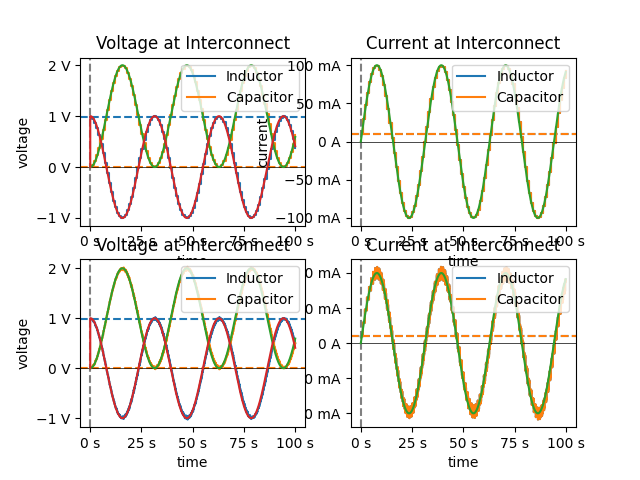

In [4]:
fig_interconnect, ax_interconnect = plt.subplot_mosaic([['V1','I1'],
                                                    ['V2','I2']])

WP.plot_time_interconnect_and_intercepts_at_time(Decimal('0'),Interface_L_big,ax_voltage = ax_interconnect['V1'],ax_current=ax_interconnect['I1'])
WP.plot_time_interconnect_and_intercepts_at_time(Decimal('0'),Interface_C_big,ax_voltage = ax_interconnect['V2'],ax_current=ax_interconnect['I2'])

ax_interconnect['V1'].plot(LTSpice_L_big['Time'],LTSpice_L_big['Capacitor_Voltage_Circuit'])
ax_interconnect['V1'].plot(LTSpice_L_big['Time'],LTSpice_L_big['Inductor_Voltage_Circuit'])
ax_interconnect['I1'].plot(LTSpice_L_big['Time'],LTSpice_L_big['Capacitor_Current_Circuit'])

ax_interconnect['V2'].plot(LTSpice_C_big['Time'],LTSpice_C_big['Capacitor_Voltage_Circuit'])
ax_interconnect['V2'].plot(LTSpice_C_big['Time'],LTSpice_C_big['Inductor_Voltage_Circuit'])
ax_interconnect['I2'].plot(LTSpice_C_big['Time'],LTSpice_C_big['Capacitor_Current_Circuit'])

(we can see the GCF(7,1) = 1 minimum timestep at play)

Why is the current much larger in the one and look much more smooth? Why are the voltage waveforms identical?

maybe reflection diagrams will expalin ....

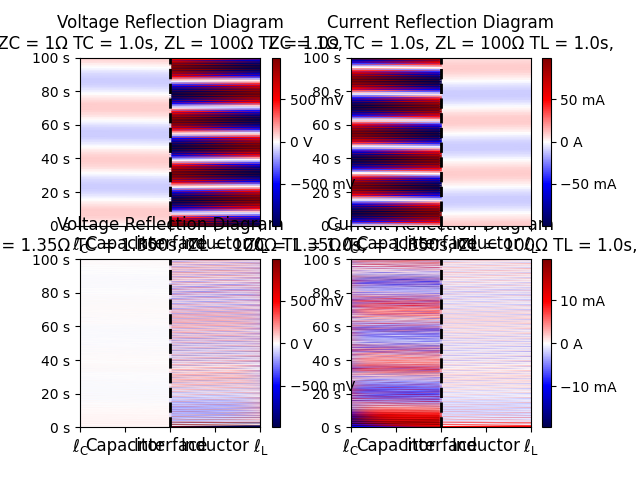

In [5]:
fig_reflection, ax_reflection = plt.subplot_mosaic([['V1','I1'],
                                                    ['V2','I2']])

WP.plot_refelction_diagram(Interface_L_big,ax_reflection['V1'],True)
WP.plot_refelction_diagram(Interface_L_big,ax_reflection['I1'],False)
WP.plot_refelction_diagram(Interface_C_big,ax_reflection['V2'],True)
WP.plot_refelction_diagram(Interface_C_big,ax_reflection['I2'],False)

Well this does show that there a discrepancy in wavefont activity, but it's not very insightful

Lets consider the fanout diagrams.

Well first we know that the commutative fanout diagrams for each case will be identical as they have the same characteristic impedance ratios:

**Big $T_L$:**

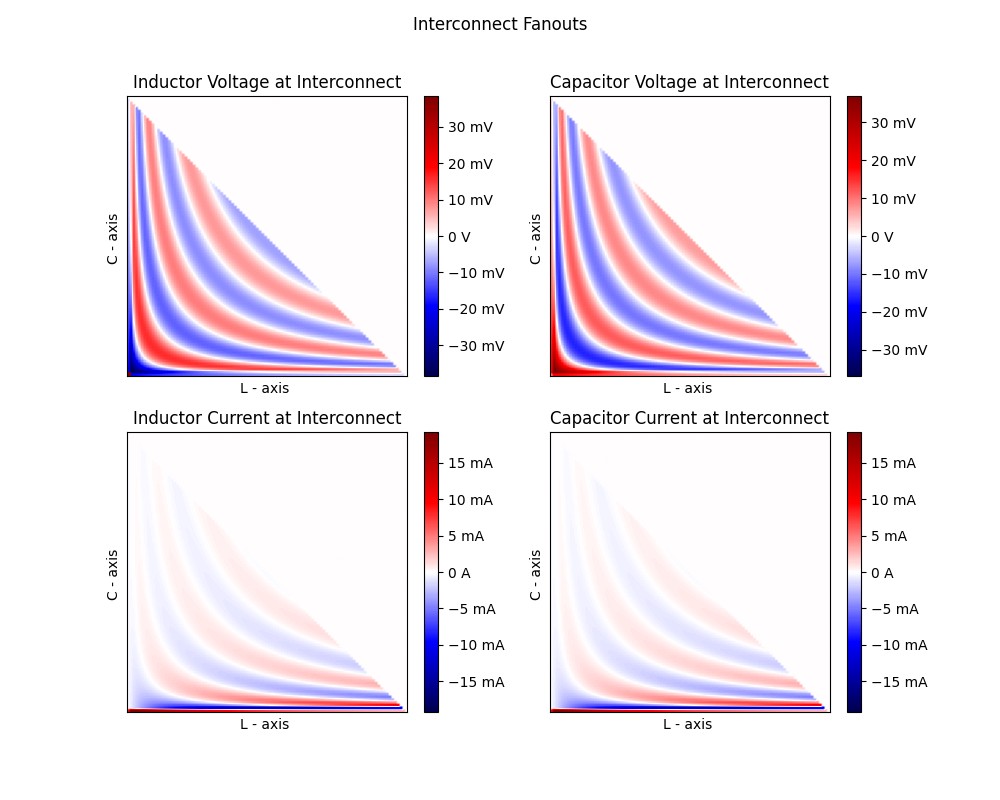

In [6]:
_,_ = WP.make_fanout_interconnect_all(Interface_L_big.data_output_commutative)

**Big $T_C$**

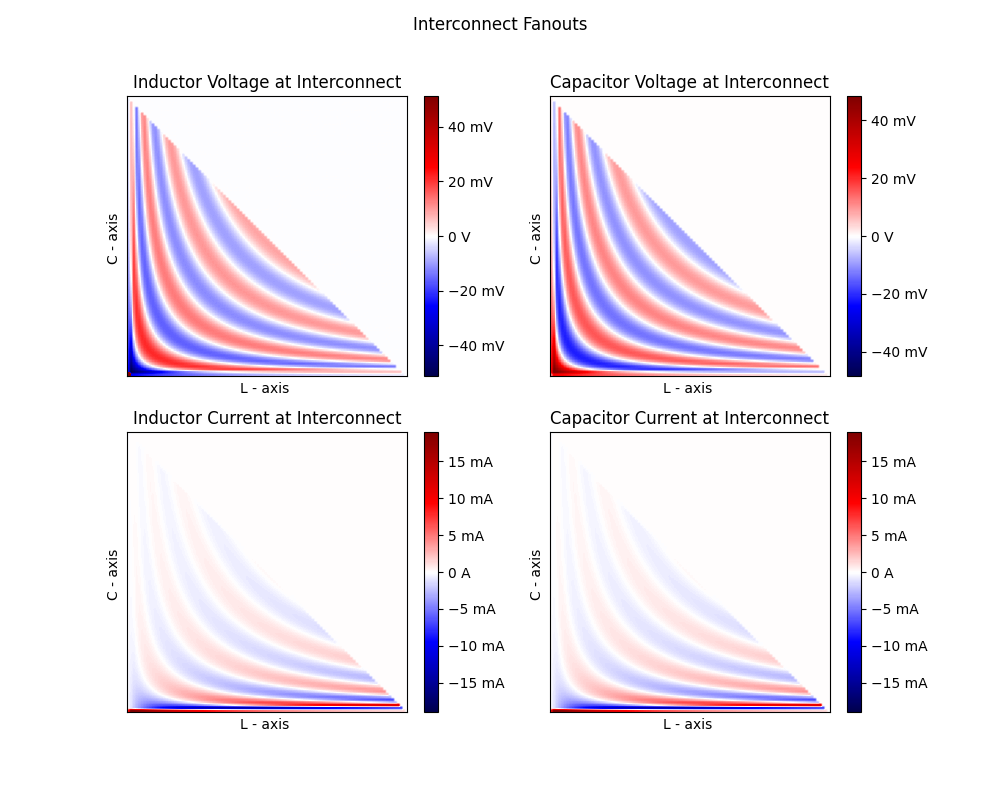

In [7]:
_,_ =WP.make_fanout_interconnect_all(Interface_C_big.data_output_commutative)

ok so as expected, they are the same. Whats intersting to note is that the voltage fanouts are symmetric, whilst the current fannouts are not.

Lets now consider their merged equivalents. Here we expect to see a discrepancy as the merging relationships differ:

**Big $T_L$:**

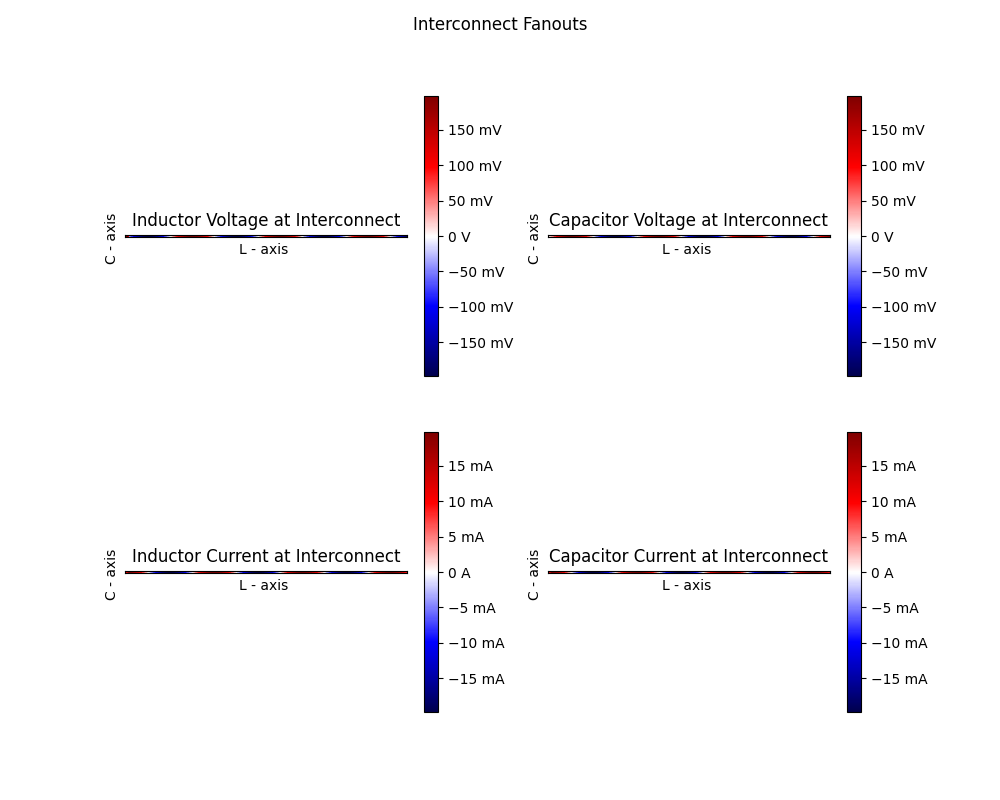

In [8]:
_,_=WP.make_fanout_interconnect_all(Interface_L_big.data_output_multiplicative)

**Big $T_C$**

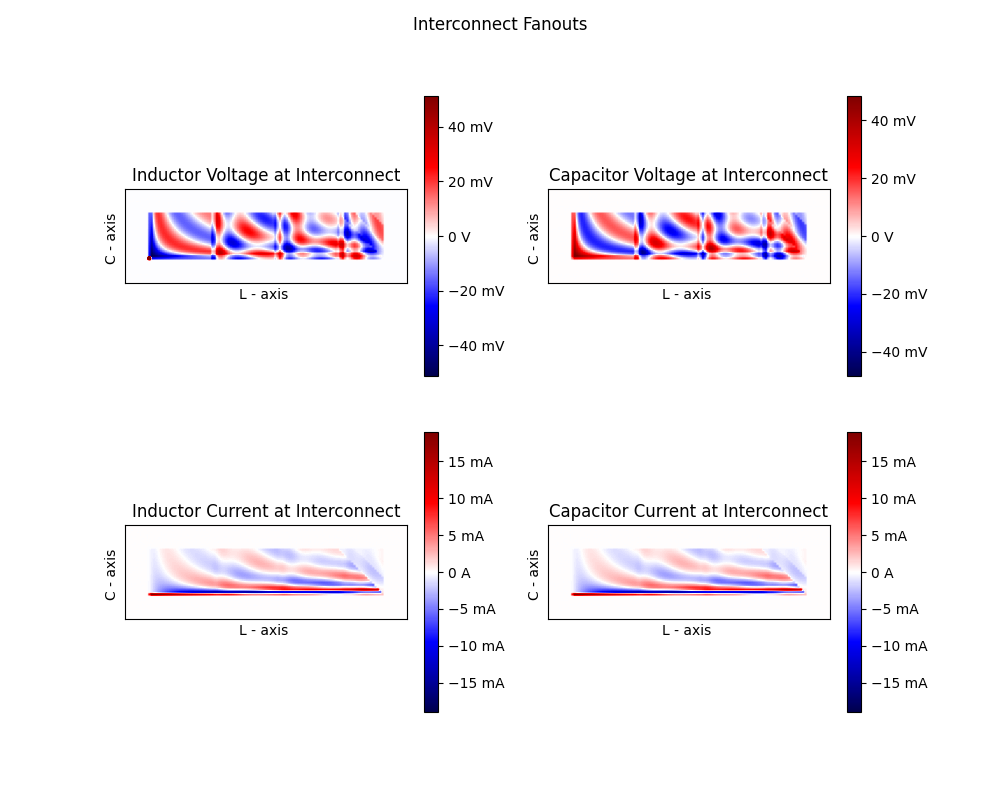

In [9]:
_,_=WP.make_fanout_interconnect_all(Interface_C_big.data_output_multiplicative,padding=10)

Here we see that the Big $T_C$ has a much more 'coherent' fanout diagram than the Big $T_L$. But why are their voltage fanouts so different when their representation in time is identical??

This is becasue the merging we show here is with respect to the **L-axis**. To make sense of that let's look at the merging regions of each fanout diagram and show their equivalent C-axis representation.  

We will start with the voltage fanouts of each case:

Text(0.5, 0.98, 'Big C')

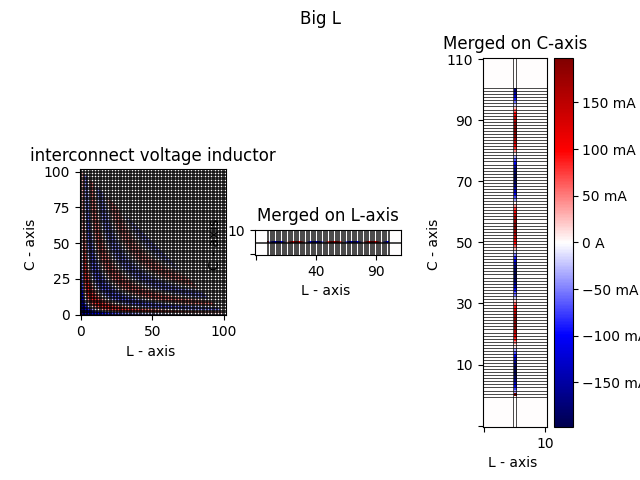

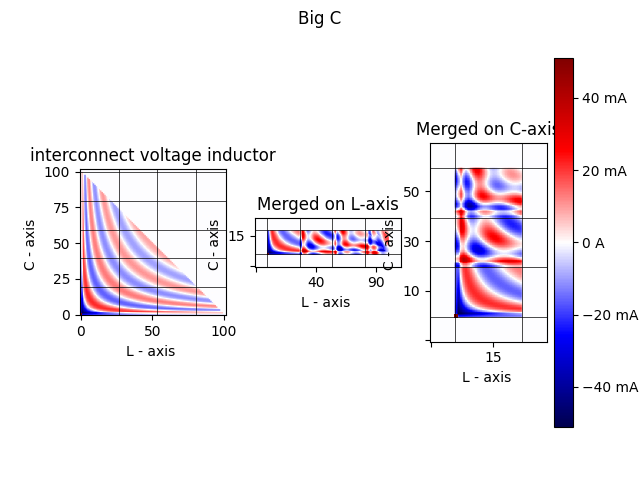

In [10]:
WP.make_commutative_merged_lines(Interface_L_big,'interconnect','voltage inductor')
plt.gcf().suptitle("Big L")

WP.make_commutative_merged_lines(Interface_C_big,'interconnect','voltage inductor')
plt.gcf().suptitle("Big C")

So we so the L-axis merging of the one is equivalent to the C-axis merging of the other. Lets consider the current fnaouts now:

Text(0.5, 0.98, 'Big C')

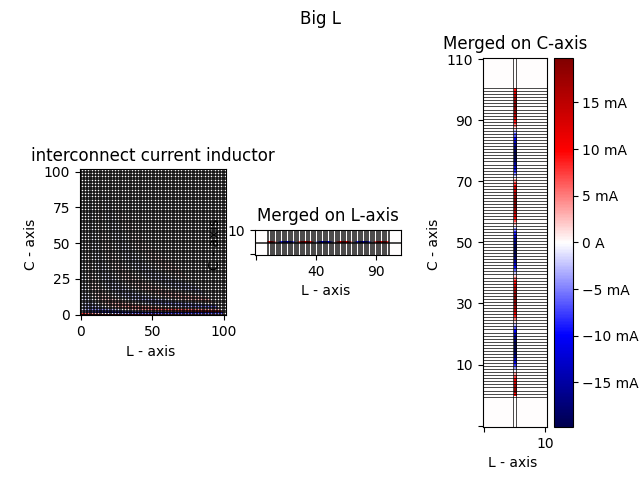

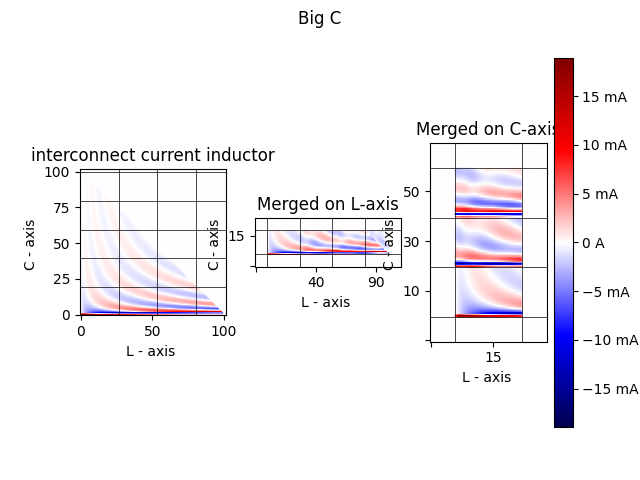

In [11]:
WP.make_commutative_merged_lines(Interface_L_big,'interconnect','current inductor')
plt.gcf().suptitle("Big L")

WP.make_commutative_merged_lines(Interface_C_big,'interconnect','current inductor')
plt.gcf().suptitle("Big C")

We see that the major contributions to creating current at the interconnect are largely accredited to the unique nodes of the Inductor (the self reflecting chain in the inductor).

This means that having as smaller inductor time delay is favourable to producing current at the interconnect as the current producing events happen more frequently in time. Futhermore the waveform as a result is smoother as the high impact self-rfelction inductive events happen consecutively rather than intermitently spaced by lower impact non-self reflected inductor events.

On top of the consecutive spacing of high impact events, the Big $T_C$ configuration has futher benefits with regards to merging high impact events with low impact events, where as the the Big $T_L$ configuration merges low impact events with other low impact events resulting in an in homogenous wavefrom.

On the other hand another important piece of information can be seen about the effect inductive and capacitive events have on the voltage at the interconnect. We can see that due to the symmetry of the voltage interconnect fanout, we can infer that when commutative merging is considered, both the inductor and capacitor contribute equally to the voltage production.

We can see these effects demonstrated interactively, we will consider only the current of each as they are the most intersting:

**Big $T_L$**

interactive(children=(FloatSlider(value=0.0, description='t', layout=Layout(width='auto')), Output()), _dom_cl…

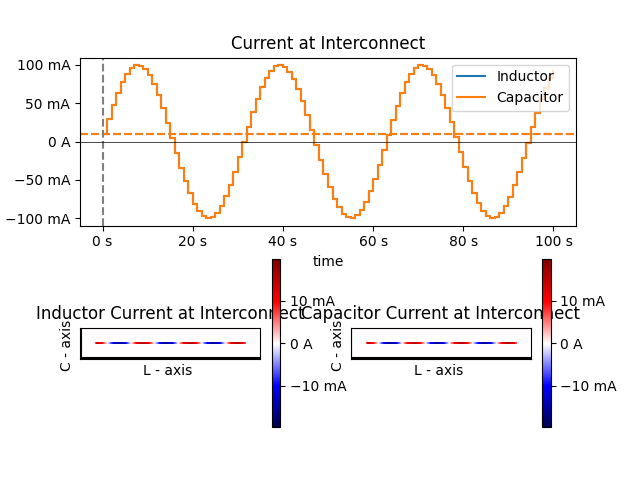

In [12]:
WI.interact_interconnect_time_and_fanout_path(Interface_L_big,False,10)

Notice how we can understand the change in the wavefrom packet shape at around 80s by considering the the 'pink spot' in the fanout diagram

**Big $T_C$**

interactive(children=(FloatSlider(value=0.0, description='t', layout=Layout(width='auto')), Output()), _dom_cl…

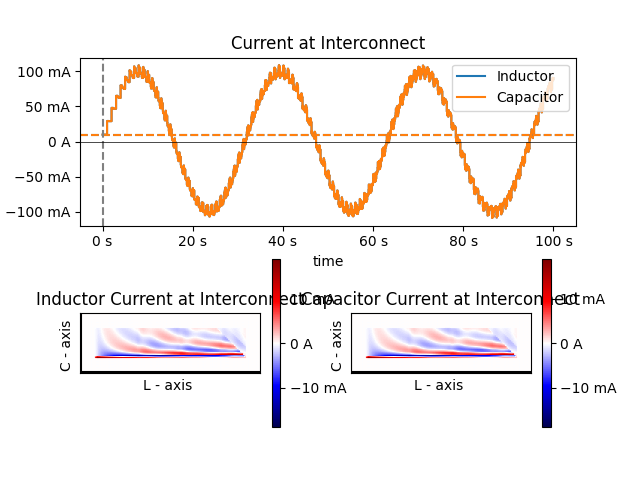

In [13]:
WI.interact_interconnect_time_and_fanout_path(Interface_C_big,False,10)

Alternatively we could compare the two interfaces by isolating wavefront beahviour, something that this technique makes possible.

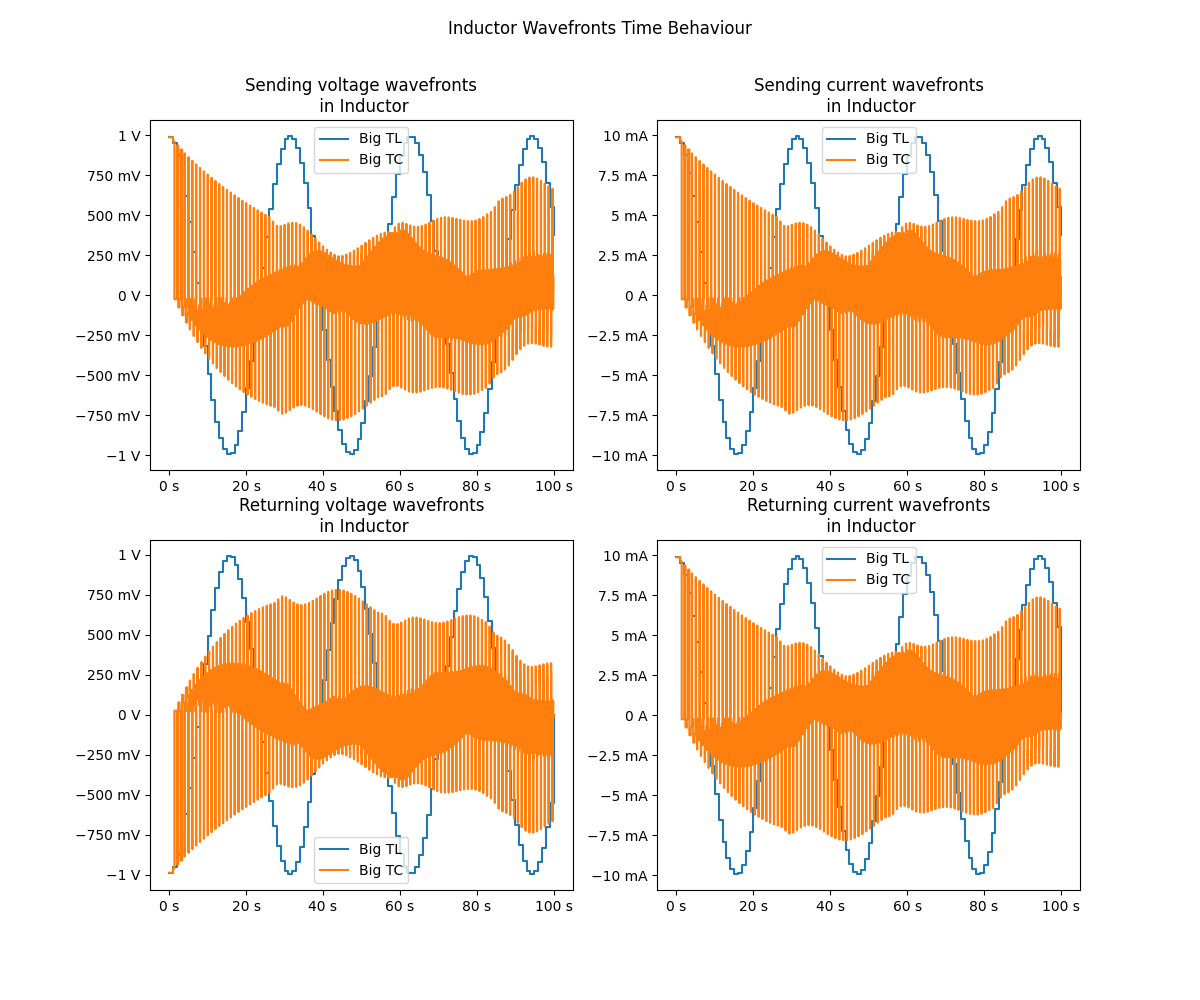

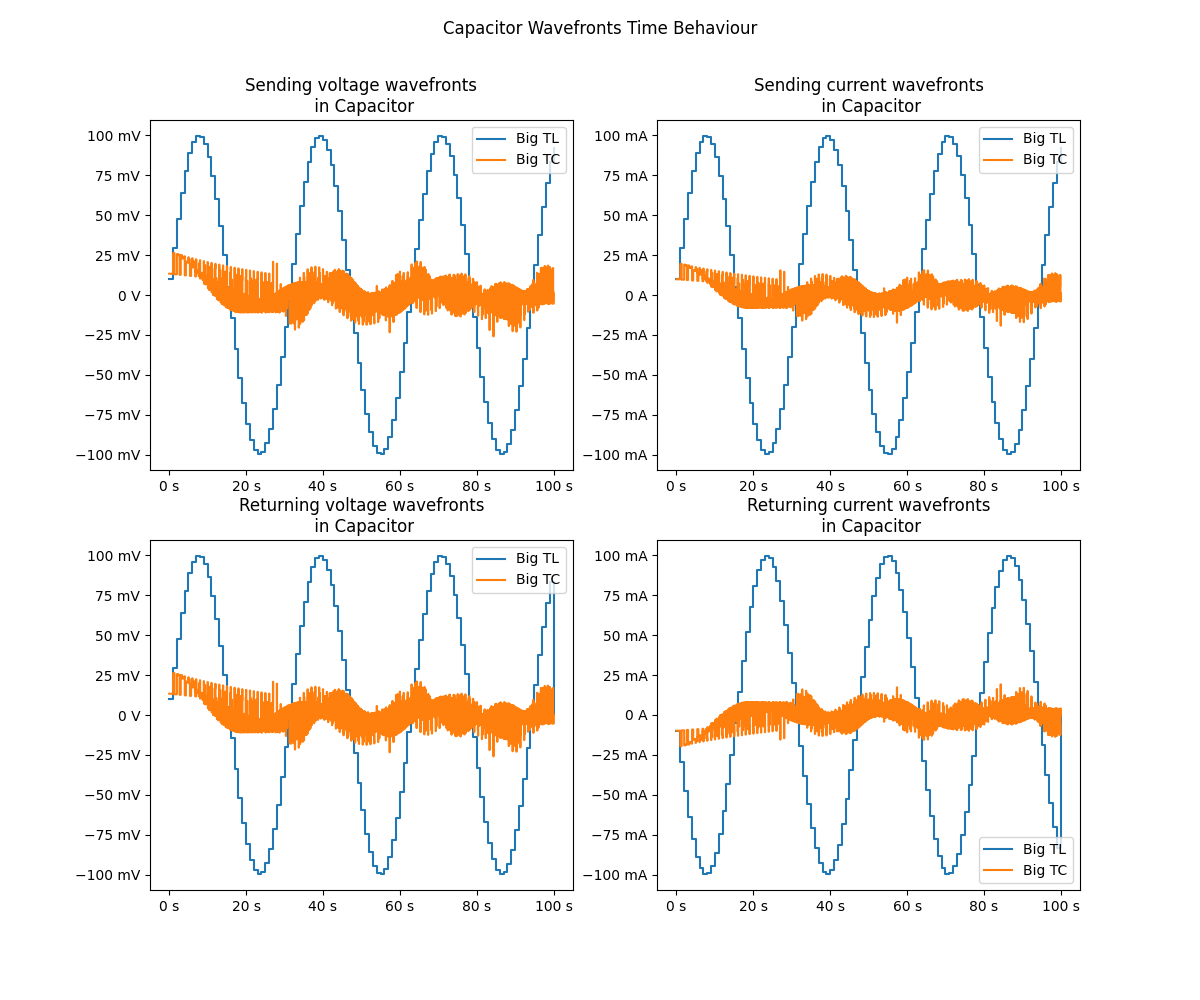

In [14]:
# inductor
fig_wave_L_time, ax_wave_L_time = WP.make_time_wavefronts_all(Interface_L_big,True,False)
WP.make_time_wavefronts_all(Interface_C_big,True,False,ax= ax_wave_L_time)

# capacitor
fig_wave_C_time, ax_wave_C_time = WP.make_time_wavefronts_all(Interface_L_big,False,False)
WP.make_time_wavefronts_all(Interface_C_big,False,False,ax= ax_wave_C_time)

for ax_L,ax_C in zip(ax_wave_L_time.values(),ax_wave_C_time.values()):
    ax_L.legend(['Big TL','Big TC'])
    ax_C.legend(['Big TL','Big TC'])

Interestingly enough, the capacitor wavefront time waveforms are remarkbly similar, despite their vastly different time delays. 

Another behaviour to consider is that of the spatial distribution of energy. This is a unique insight providied by the technique:  

**Big $T_L$**:

interactive(children=(FloatSlider(value=0.0, description='t', layout=Layout(width='auto')), Output()), _dom_cl…

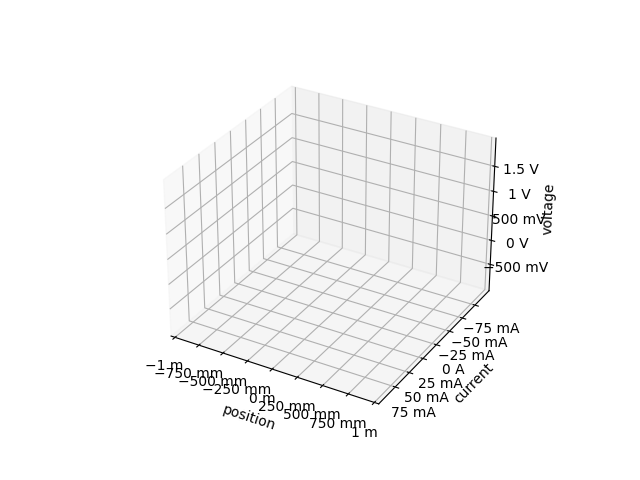

In [15]:
WI.interact_3D_spatial(Interface_L_big)

**Big $T_C$**:

interactive(children=(FloatSlider(value=0.0, description='t', layout=Layout(width='auto')), Output()), _dom_cl…

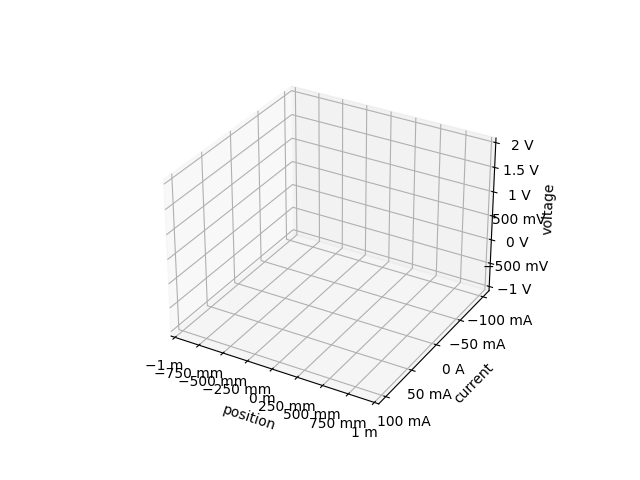

In [16]:
WI.interact_3D_spatial(Interface_C_big)

Here we can see in big $T_L$ the capacitor is constantly discharging, where as in big $T_C$ the capacitor stores energy. 

We can also represent this data in a more conventional way:

GridspecLayout(children=(Button(description='step backward', layout=Layout(grid_area='widget001', width='auto'…

FloatSlider(value=0.0, layout=Layout(width='auto'), max=171.07211628637563)

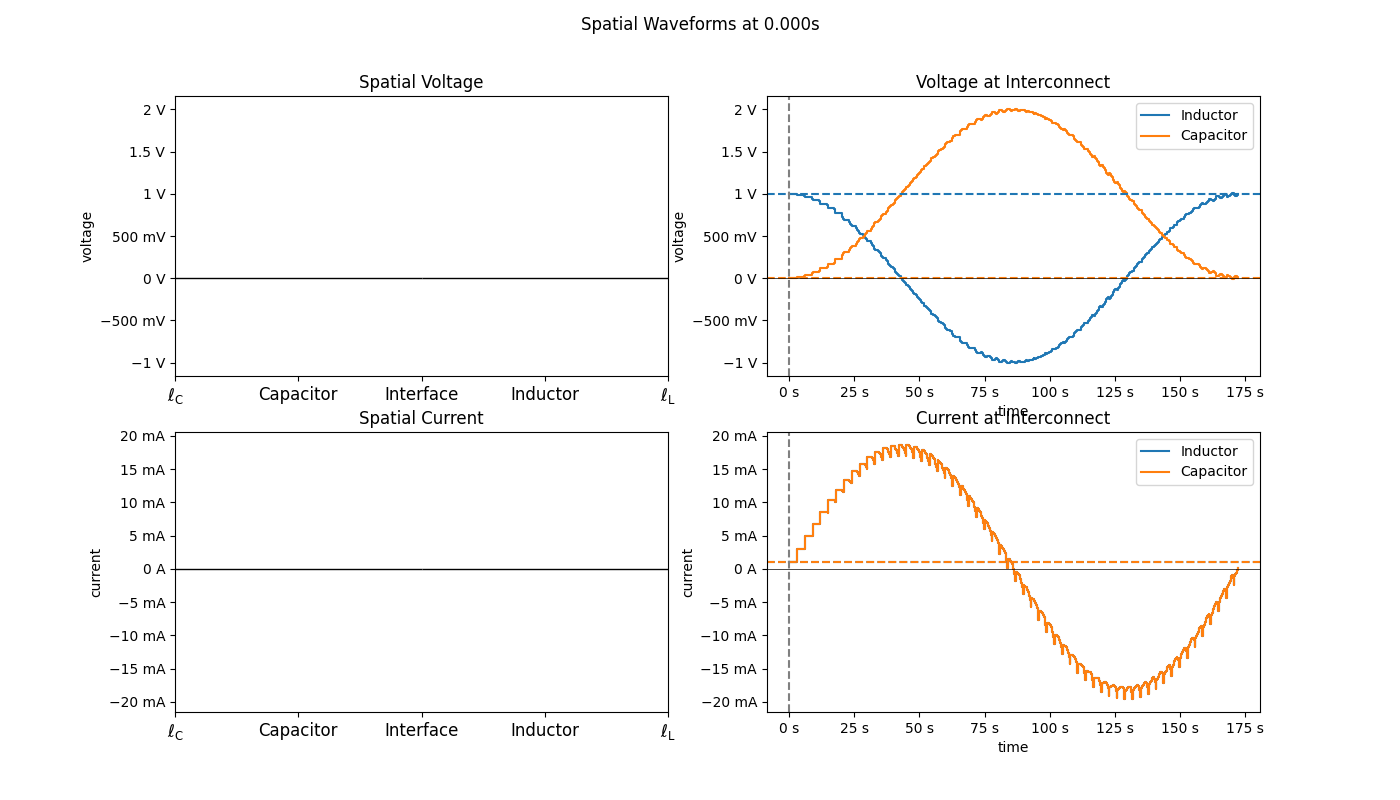

In [89]:
WI.spatial_interconnect_investigator_ui(Interface_L_big)

GridspecLayout(children=(Button(description='step backward', layout=Layout(grid_area='widget001', width='auto'…

FloatSlider(value=0.0, layout=Layout(width='auto'), max=171.07211628637563)

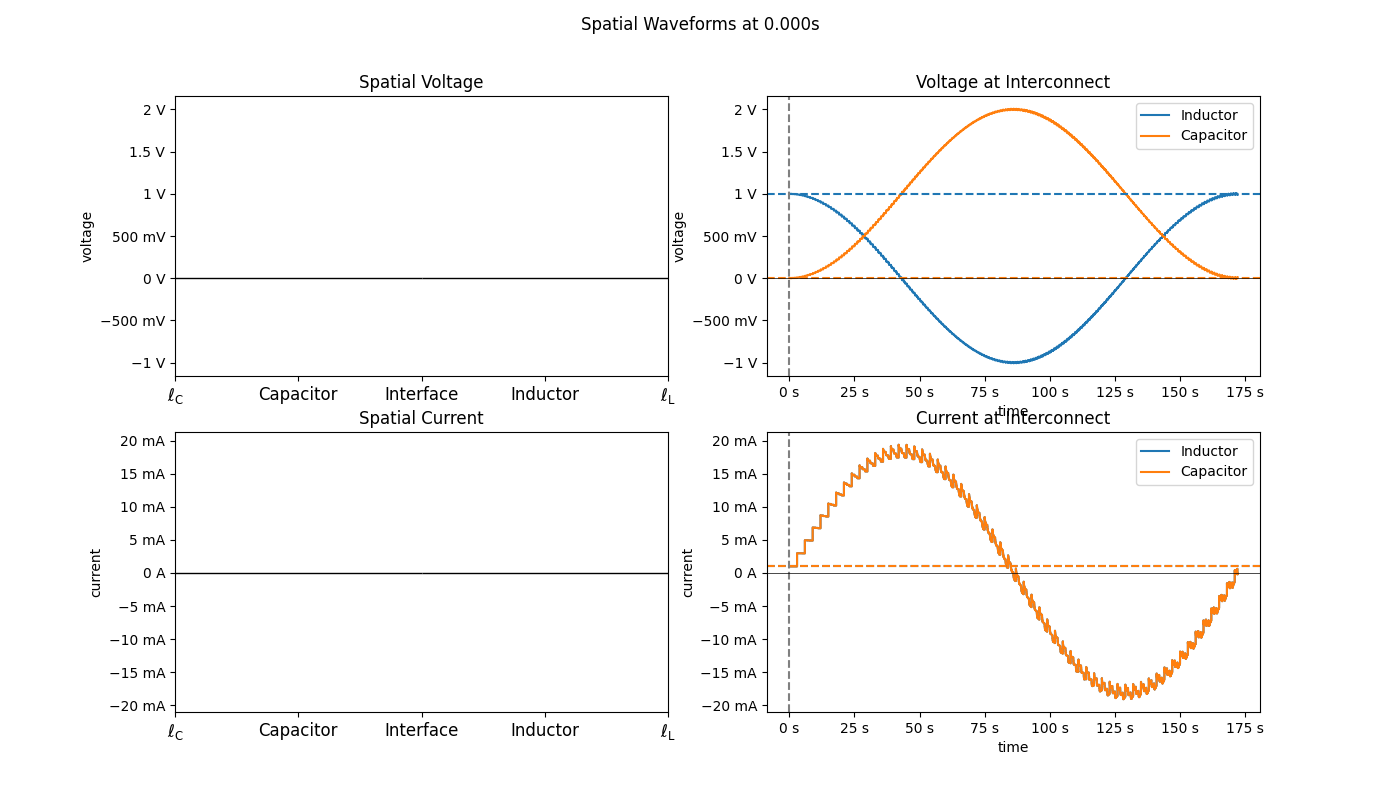

In [87]:
WI.spatial_interconnect_investigator_ui(Interface_C_big)